## Customer Segmentation and Clustering


In [12]:
#importing necessary libraries and the dataset
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
%matplotlib inline

CleanDataset = r'D:\SEM 4\DAB402 - CAPSTONE PROJECT\Cleansed_Dataset\OnlineRetail_Cleaned_1.csv'
Data_Cleaned = pd.read_csv(CleanDataset, index_col = 'InvoiceDate')
Data_Cleaned.index = pd.to_datetime(Data_Cleaned.index, format = '%m-%d-%Y %H:%M')

In [13]:
#grouping the data by customers and preparing for segmentation
Data = Data_Cleaned.copy()
Data['Country'] = Data['Country'].map(lambda x: 'UK' if x=='United Kingdom' else 'Non-UK')
CustomerData = Data.groupby(['CustomerID','Country'], sort=False).agg({'Quantity':'mean','UnitPrice':'mean','InvoiceNo':'nunique','Description':'nunique'})
CustomerData.reset_index(inplace=True)
CustomerData.columns = ['CustomerID', 'UK?', 'Average Quantity', 'Average Price', 'Repeats', 'Product Variety']
CustomerData.head()

,CustomerID,UK?,Average Quantity,Average Price,Repeats,Product Variety
0,17850.0,UK,5.426282,3.924712,35,25
1,13047.0,UK,6.913265,4.072959,18,106
2,12583.0,Non-UK,19.956175,3.152510,18,117
3,13748.0,UK,15.678571,3.996429,5,24
4,15100.0,UK,9.666667,10.950000,6,1


In [14]:
#scaling the numerical features for clustering
Scaler = StandardScaler()
CustomerData.iloc[:,2:] = Scaler.fit_transform(CustomerData.iloc[:,2:])
syms = CustomerData.iloc[:,0].values.astype(str)
X = CustomerData.iloc[:,1:].values.astype(object)
#finding the optimal cluster_number k
for n in range(2,8):
    kproto = KPrototypes(n_clusters = n, init = 'Cao')
    clusters = kproto.fit_predict(X, categorical = [0])
    silhouette = silhouette_score(X[:,1:],clusters)
    print('number of clusters:', n)
    print('  cost: ',kproto.cost_)
    print('  average silhouette score: ',silhouette)

number of clusters: 2
  cost:  14079.685342128862
  average silhouette score:  0.9715949040799902
number of clusters: 3
  cost:  10847.49102941009
  average silhouette score:  0.7320619539611608
number of clusters: 4
  cost:  7744.115482420717
  average silhouette score:  0.7439950823041406
number of clusters: 5
  cost:  5574.193584848911
  average silhouette score:  0.6565060822997526
number of clusters: 6
  cost:  4663.005522894017
  average silhouette score:  0.5587966205173391
number of clusters: 7
  cost:  3859.208617456184
  average silhouette score:  0.5433479102037697


In [15]:
#clustering with kprototypes with k = 4
kproto = KPrototypes(n_clusters = 4, init = 'Cao')
clusters = kproto.fit_predict(X, categorical = [0])
print('Cluster Centers:\n', kproto.cluster_centroids_)

Cluster Centers:
 [['-0.03184004039078561' '-0.030113939473244398' '2.0266819317430804'
  '2.3269325513711383' 'UK']
 ['-0.07920575999811011' '42.524078602249126' '-0.22226923358839712'
  '-0.690326891730964' 'UK']
 ['39.38230817478366' '-0.05256143074382534' '-0.4364550588580589'
  '-0.7019165941292645' 'UK']
 ['-0.01691995857549319' '-0.018617602617552135' '-0.1571890846075036'
  '-0.1801626614138132' 'UK']]


In [16]:
#retrieving all attributes
Clustered = pd.DataFrame(data=Scaler.inverse_transform(CustomerData.iloc[:,2:]),columns=['Average Quantity', 'Average Price', 'Repeats', 'Product Variety'])
Clustered['UK?'] = X[:,0]
Clustered['CustomerID'] = syms
Clustered['Cluster'] = clusters
print(Clustered.groupby(['Cluster','UK?']).count()['Repeats'],'\n\n\n')
print(Clustered.groupby(['Cluster','UK?']).mean())

Cluster  UK?   
0        Non-UK      32
         UK         283
1        UK           2
2        UK           2
3        Non-UK     390
         UK        3663
Name: Repeats, dtype: int64 



                Average Quantity  Average Price    Repeats  Product Variety
Cluster UK?                                                                
0       Non-UK         17.918832       5.474316  28.687500       305.718750
        UK             15.337731       3.403302  23.469965       257.434629
1       UK              5.500000    6171.705000   3.000000         2.000000
2       UK           8420.000000       0.360000   1.000000         1.000000
3       Non-UK         17.773379       7.799897   3.628205        49.233333
        UK             18.888716       5.011758   3.605515        45.676495


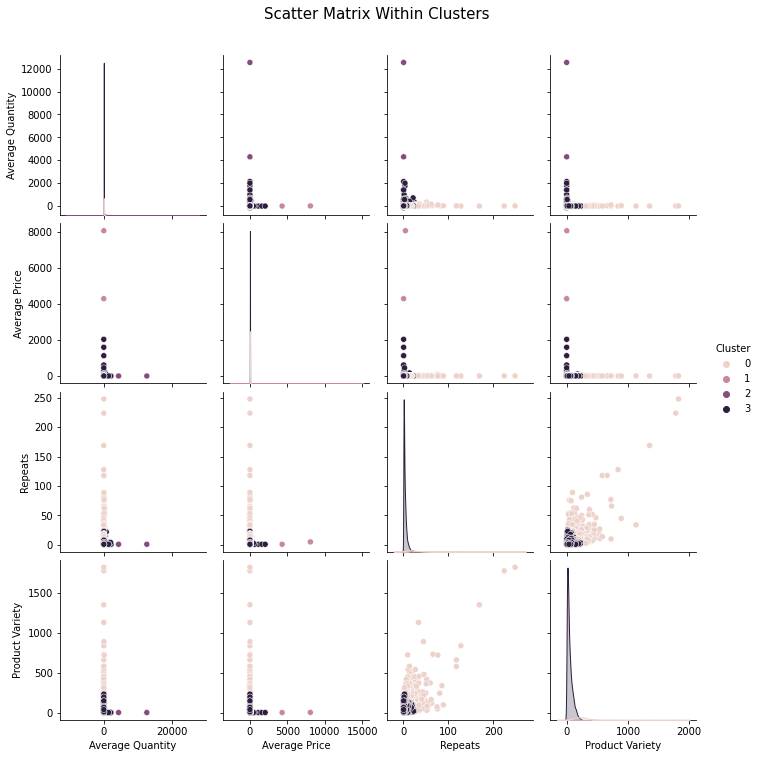

In [17]:
#comparison plots
sns.pairplot(Clustered.drop(columns=['UK?','CustomerID']), hue='Cluster')
plt.suptitle('Scatter Matrix Within Clusters', fontsize = 15, y = 1.05)
plt.show()